In [1]:
from __future__ import print_function

from collections import defaultdict

import requests

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def do_request(service, a1=None, a2=None, a3=None, **kwargs):
    server = 'http://api.gbif.org/v1'
    params = ''
    for a in [a1, a2, a3]:
        if a is not None:
            params += '/' + a
    req = requests.get('%s/%s%s' % (server, service, params),
                       params=kwargs,
                       headers={'Content-Type': 'application/json'})
    if not req.ok:
        req.raise_for_status()
    return req.json()

In [3]:
req = do_request('species', 'search', q='bear')
print(req['count'])
req['results'][0]

19206


{u'authorship': u'',
 u'canonicalName': u'Ursus white bear',
 u'class': u'Mammalia',
 u'classKey': 106223020,
 u'datasetKey': u'fab88965-e69d-4491-a04d-e3198b626e52',
 u'descriptions': [],
 u'family': u'Ursidae',
 u'familyKey': 106657396,
 u'genus': u'Ursus',
 u'genusKey': 106658119,
 u'habitats': [],
 u'higherClassificationMap': {u'106148414': u'Metazoa',
  u'106151875': u'Carnivora',
  u'106223020': u'Mammalia',
  u'106522535': u'Chordata',
  u'106657396': u'Ursidae',
  u'106658119': u'Ursus'},
 u'key': 106189791,
 u'kingdom': u'Metazoa',
 u'kingdomKey': 106148414,
 u'nameType': u'SCINAME',
 u'nomenclaturalStatus': [],
 u'numDescendants': 0,
 u'numOccurrences': 0,
 u'order': u'Carnivora',
 u'orderKey': 106151875,
 u'parent': u'Ursus',
 u'parentKey': 106658119,
 u'phylum': u'Chordata',
 u'phylumKey': 106522535,
 u'rank': u'SPECIES',
 u'scientificName': u'Ursus sp. Shennongjia white bear',
 u'species': u'Ursus white bear',
 u'speciesKey': 106189791,
 u'synonym': False,
 u'taxonID': u'3

In [4]:
req_short = do_request('species', 'search', q='bear', rank='family')
print(req_short['count'])
bear = req_short['results'][0]
bear

645


{u'authorship': u'G. Fischer de Waldheim, 1817',
 u'canonicalName': u'Ursidae',
 u'class': u'Mammalia',
 u'classKey': 143045262,
 u'datasetKey': u'cbb6498e-8927-405a-916b-576d00a6289b',
 u'descriptions': [{u'description': u'Below follows a list of the different species of bears. Bears indented are a subspecies or type of the species listed above it that is non-indented.'},
  {u'description': u'American Black Bear Cinnamon Bear Kermode Bear Asiatic Black Bear Baluchistan Bear or Pakistan Black Bear Formosan black bear Brown bear Atlas bear Bergman\'s bear Blue bear Eurasian brown bear European brown bear Gobi bear Grizzly bear Himalayan brown bear Nandi bear Ussuri brown bear Kamchatka brown bear Kodiak bear Marsican brown bear (critically endangered) Mexican grizzly bear East Siberian brown bear Syrian brown bear Giant Panda Qinling Panda Sloth bear Sri Lankan sloth bear Sun bear Polar bear Ursid hybrid Grizzly\u2013polar bear hybrid Spectacled Bear Extinct bear species Agriotherium Tr

In [5]:
import time
def get_all_records(rec_field, service, a1=None, a2=None, a3=None, **kwargs):
    records = []
    all_done = False
    offset = 0
    num_iter = 0
    while not all_done and num_iter < 100:  # arbitrary
        req = do_request(service, a1=a1, a2=a2, a3=a3, offset=offset, **kwargs)
        all_done = req['endOfRecords']
        if not all_done:
            time.sleep(1)
        offset += req['limit']
        records.extend(req[rec_field])
        num_iter += 1
    return records

In [6]:
def get_leaves(nub):
    leaves = []
    recs = get_all_records('results', 'species', str(nub), 'children')
    if len(recs) == 0:
        return None
    for rec in recs:
        rec_leaves = get_leaves(rec['nubKey'])
        if rec_leaves is None:
            leaves.append(rec)
        else:
            leaves.extend(rec_leaves)
    return leaves

In [7]:
records = get_all_records('results', 'species', str(bear['nubKey']), 'children')
leaves = get_leaves(bear['nubKey'])

In [8]:
#[leaf['nameType'] for leaf in leaves]
for rec in leaves:
    print(rec['scientificName'], rec['rank'], end=' ')
    vernaculars = do_request('species', str(rec['nubKey']), 'vernacularNames', language='en')['results']
    for vernacular in vernaculars:
        if vernacular['language'] == 'eng':
            print(vernacular['vernacularName'], end='')
            break
    print()

Agriarctos Kretzoi, 1942 GENUS 
Ailurarctos Qiu Zhanxiang & Qi Guoquin, 1989 GENUS 
Ailuropoda baconi SPECIES 
Ailuropoda fovealis SPECIES 
Ailuropoda melanoleuca (David, 1869) SPECIES Bamboo Bear
Ailuropoda microta SPECIES 
Ailuropoda wulingshanensis SPECIES 
Cynodon helveticus SPECIES 
Arctodus pristinus SPECIES 
Arctodus simus SPECIES 
Harpaleocyon Hürzeler, 1944 GENUS 
Helarctos malayanus euryspilus Horsfield, 1825 SUBSPECIES 
Helarctos malayanus subsp. malayanus SUBSPECIES 
Hyaenarctos Owen, 1845 GENUS 
Indarctos anthracitis SPECIES 
Indarctos arctoides SPECIES 
Indarctos atticus SPECIES 
Indarctos nevadensis SPECIES 
Indarctos oregonensis SPECIES 
Indarctos salmontanus SPECIES 
Indarctos vireti SPECIES 
Indarctos zdanskyi SPECIES 
Melursus ursinus inornatus Pucheran, 1855 SUBSPECIES Sri Lankan Sloth Bear
Melursus ursinus ursinus (Shaw, 1791) SUBSPECIES 
Metarctos Gaudry, 1860 GENUS 
Myadus GENUS 
Pararctotherium Ameghino, 1904 GENUS 
Phoberocyon aurelianensis SPECIES 
Phoberocyon

In [9]:
basis_of_record = defaultdict(int)
country = defaultdict(int)
zero_occurrences = 0
count_extinct = 0
for rec in leaves:
    #print(rec['scientificName'], rec['rank'], rec['taxonID'])
    occurrences = get_all_records('results', 'occurrence', 'search', taxonKey=rec['nubKey'])
    for occurrence in occurrences:
        basis_of_record[occurrence['basisOfRecord']] += 1
        country[occurrence.get('country', 'NA')] += 1
        #there is also publisingCountry
    if len(occurrences) > 0:
        zero_occurrences += 1
    profiles = do_request('species', str(rec['nubKey']), 'speciesProfiles')['results']
    for profile in profiles:
        if profile.get('extinct', False):
            count_extinct += 1
            break

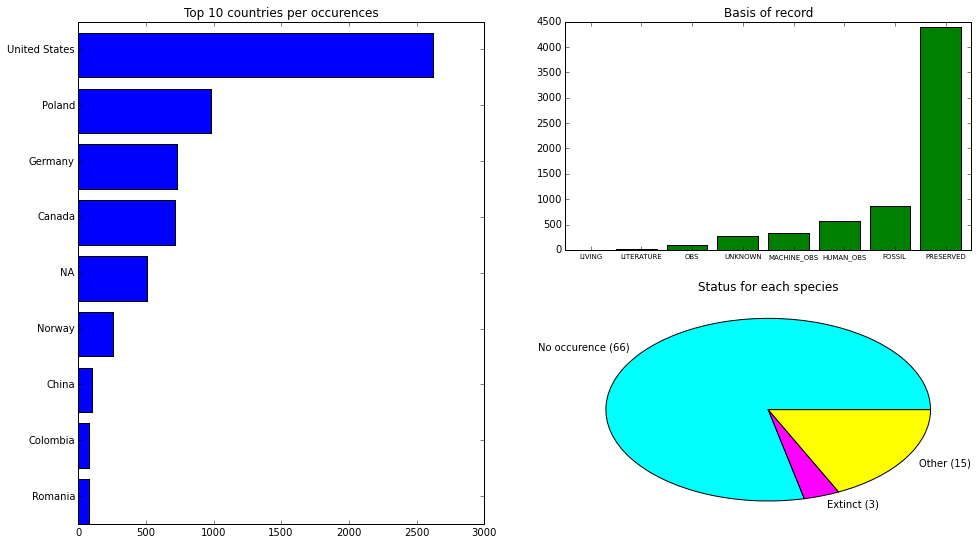

In [10]:
countries, obs_countries = zip(*sorted(country.items(), key=lambda x: x[1]))
basis_name, basis_cnt = zip(*sorted(basis_of_record.items(), key=lambda x: x[1]))
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(1, 2, 1)
ax.barh(np.arange(10) - 0.5, obs_countries[-10:])
ax.set_title('Top 10 countries per occurences')
ax.set_yticks(range(10))
ax.set_ylim(0.5, 9.5)
ax.set_yticklabels(countries[-10:])
#refer metadata problems

ax = fig.add_subplot(2, 2, 2)
ax.set_title('Basis of record')
ax.bar(np.arange(len(basis_name)), basis_cnt, color='g')
basis_name = [x.replace('OBSERVATION', 'OBS').replace('_SPECIMEN', '') for x in basis_name]
ax.set_xticks(0.5 + np.arange(len(basis_name)))
ax.set_xticklabels(basis_name, size='x-small')

ax = fig.add_subplot(2, 2, 4)
other = len(leaves) - zero_occurrences - count_extinct
pie_values = [zero_occurrences, count_extinct, other]
labels = ['No occurence (%d)' % zero_occurrences,
          'Extinct (%d)' % count_extinct, 'Other (%d)' % other]
ax.pie(pie_values, labels=labels,
       colors=['cyan', 'magenta', 'yellow'])
ax.set_title('Status for each species')

In [11]:
#distribution of observations of horribilis per year
#probably not put...

In [12]:
horribilis = get_all_records('results', 'occurrence', 'search', taxonKey=6163845)

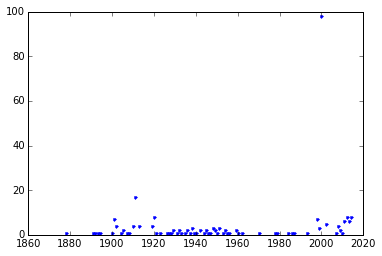

In [13]:
years = defaultdict(int)
for x in horribilis:
    years[x.get('year', None)] += 1
xs, ys = zip(*[(y, cnt) for y, cnt in years.items() if y is not None])
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(xs, ys, '.')